In [0]:
# CISC642 PR3-2 - Matthew Leinhauser

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


Downloading: "https://download.pytorch.org/models/fcn_resnet101_coco-7ecb50ca.pth" to /root/.cache/torch/checkpoints/fcn_resnet101_coco-7ecb50ca.pth



2020-05-13 13:45:12 URL:https://i.ytimg.com/vi/RZ3o5S61lBY/hqdefault.jpg [16255/16255] -> "bird_cat_dog.png" [1]
2020-05-13 13:45:15 URL:https://arthive.com/res/media/img/oy800/work/439/164355.jpg [97695/97695] -> "cow_sheep_horse.png" [1]
2020-05-13 13:45:18 URL:https://image.shutterstock.com/image-photo/single-man-on-couch-watching-260nw-130173635.jpg [12118/12118] -> "tv_sofa_person.png" [1]
2020-05-13 13:45:20 URL:https://assets.vogue.com/photos/5c8ff73ac712fa2de624c06d/master/w_1600%2Cc_limit/01-boys-with-plants-book.jpg [441741/441741] -> "person_with_plants.png" [1]
2020-05-13 13:45:23 URL:https://www.slate.com/content/dam/slate/articles/technology/future_tense/2014/02/140203_FT_ComparingTransportation.jpg.CROP.promo-mediumlarge.jpg [226385/226385] -> "bus_plane_car_train.png" [1]


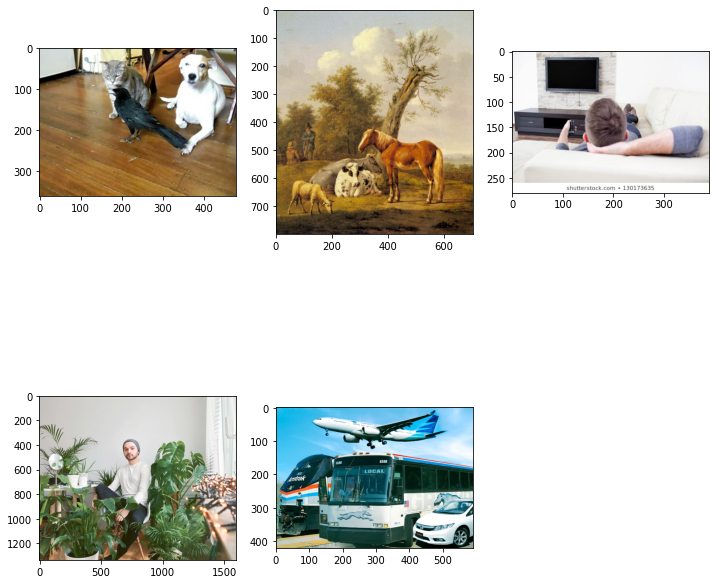

In [2]:
# load the ResNet101 model wiith pretrained weights and set it to inference mode
model = models.segmentation.fcn_resnet101(pretrained=True).eval()

# load five images
!wget -nv https://i.ytimg.com/vi/RZ3o5S61lBY/hqdefault.jpg -O bird_cat_dog.png
img1 = Image.open('./bird_cat_dog.png')
!wget -nv https://arthive.com/res/media/img/oy800/work/439/164355.jpg -O cow_sheep_horse.png
img2 = Image.open('./cow_sheep_horse.png')
!wget -nv https://image.shutterstock.com/image-photo/single-man-on-couch-watching-260nw-130173635.jpg -O tv_sofa_person.png
img3 = Image.open('./tv_sofa_person.png')
!wget -nv https://assets.vogue.com/photos/5c8ff73ac712fa2de624c06d/master/w_1600%2Cc_limit/01-boys-with-plants-book.jpg -O person_with_plants.png
img4 = Image.open('./person_with_plants.png')
!wget -nv https://www.slate.com/content/dam/slate/articles/technology/future_tense/2014/02/140203_FT_ComparingTransportation.jpg.CROP.promo-mediumlarge.jpg -O bus_plane_car_train.png
img5 = Image.open('./bus_plane_car_train.png')

# Show the five input images
input_images = plt.figure(figsize=(12, 12))

input_images.add_subplot(2, 3, 1)
plt.imshow(img1)

input_images.add_subplot(2, 3, 2)
plt.imshow(img2)

input_images.add_subplot(2, 3, 3)
plt.imshow(img3)

input_images.add_subplot(2, 3, 4)
plt.imshow(img4)

input_images.add_subplot(2, 3, 5)
plt.imshow(img5)

plt.show()

In [0]:
# resize the images to be the same size, convert them to be Tensor Objects, and
# normalize the tensor values based on the ImageNet specific mean and standard
# deviation
data_transforms = transforms.Compose([transforms.Resize((256, 256)),
                                transforms.CenterCrop((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])])

In [0]:
# unsqueeze the images so we can pass them through the network
input_1 = data_transforms(img1).unsqueeze(0)
input_2 = data_transforms(img2).unsqueeze(0)
input_3 = data_transforms(img3).unsqueeze(0)
input_4 = data_transforms(img4).unsqueeze(0)
input_5 = data_transforms(img5).unsqueeze(0)

In [0]:
# Perform the forward pass
# i.e. send inputs through the FCN
output_1 = model(input_1)['out']
output_2 = model(input_2)['out']
output_3 = model(input_3)['out']
output_4 = model(input_4)['out']
output_5 = model(input_5)['out']

In [0]:
# create a helper function to get the 21 feature maps for each tensor
def get_feature_maps(img, num_channels=21):
  feature_maps = []
  feature_mosaic = plt.figure(figsize=(12, 12))
  j = 1
  # get the feature maps for each channel/dataset class of the tensor
  for i in range(num_channels):
    feature_maps.append(img[0][i])
    # convert the tensors to images
    feature_maps[i] = feature_maps[i].detach().cpu().numpy()
    
    # tile the feature maps into one image
    feature_mosaic.add_subplot(7, 3, j)
    plt.imshow(feature_maps[i])
    j += 1

  # show the feature maps together
  plt.show()

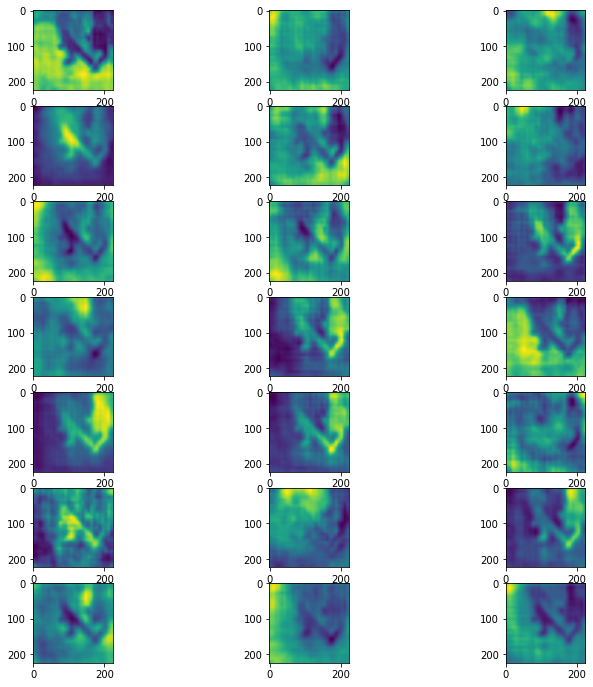

In [7]:
# Show the feature maps for the first image
get_feature_maps(output_1)

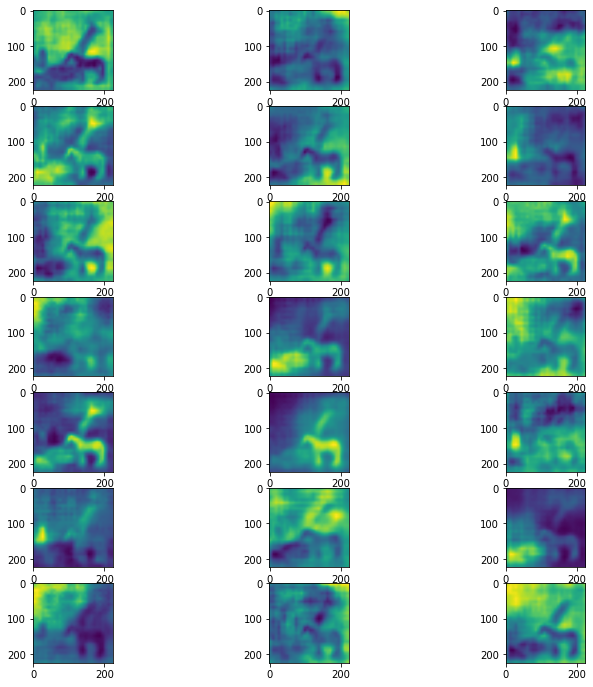

In [8]:
# Show the feature maps for the second image
get_feature_maps(output_2)

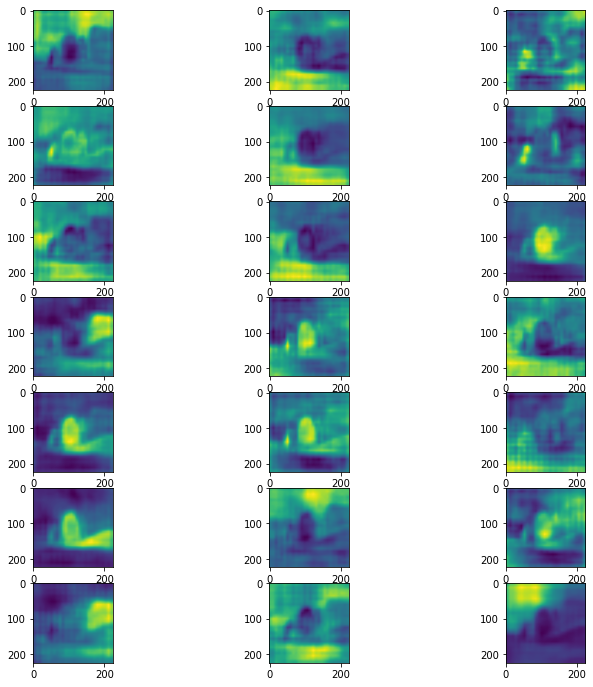

In [9]:
# Show the feature maps for the third image
get_feature_maps(output_3)

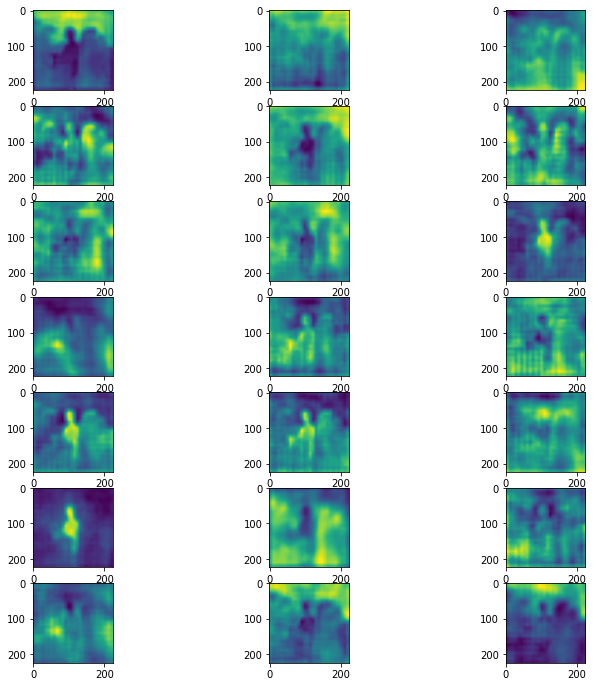

In [10]:
# Show the feature maps for the fourth image
get_feature_maps(output_4)

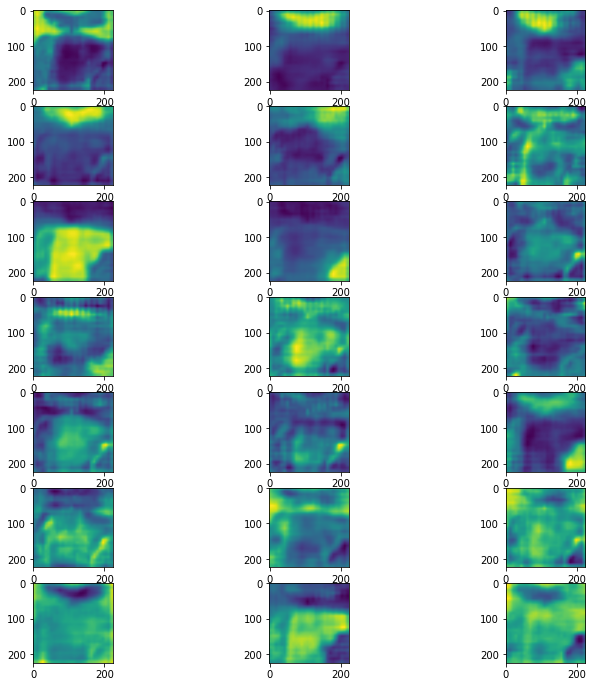

In [11]:
# Show the feature maps for the fifth image
get_feature_maps(output_5)

In [0]:
# get the max for each pixel and assign that pixel to a class for each image
output_max_1 = torch.argmax(output_1.squeeze(), dim=0).detach().cpu().numpy()
output_max_2 = torch.argmax(output_2.squeeze(), dim=0).detach().cpu().numpy()
output_max_3 = torch.argmax(output_3.squeeze(), dim=0).detach().cpu().numpy()
output_max_4 = torch.argmax(output_4.squeeze(), dim=0).detach().cpu().numpy()
output_max_5 = torch.argmax(output_5.squeeze(), dim=0).detach().cpu().numpy()

In [0]:
# create the helper function to decode the segmentation map
# i.e. assign a color for each class
def segmentation_map_key(img, num_class=21):
  class_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle,    3=bird,       4=boat,     
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), 

               # 5=bottle,        6=bus,        7=car,          8=cat,
               (128, 0, 128), (0, 128, 128), (128, 128, 128), (64, 0, 0),

               # 9=chair,       10=cow,  11=dining table,   12=dog,
               (192, 0, 0), (64, 128, 0), (192, 128, 0), (64, 0, 128),

               # 13=horse,      14=motorbike,     15=person, 16=potted plant,
               (192, 0, 128), (64, 128, 128), (192, 128, 128), (0, 64, 0),
               
               # 17=sheep,      18=sofa,    19=train,    20=tv/monitor
               (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])
  
  red = np.zeros_like(img).astype(np.uint8)
  green = np.zeros_like(img).astype(np.uint8)
  blue = np.zeros_like(img).astype(np.uint8)
  
  # because we want to create the segmentation maps, we need to assign each
  # image channel a class defined above
  for label in range(num_class):
    index = img == label
    red[index] = class_colors[label, 0]
    green[index] = class_colors[label, 1]
    blue[index] = class_colors[label, 2]
    
  # add the channels to the greyscale image and return the colored segmentation map
  colored = np.stack([red, green, blue], axis=2)
  return colored

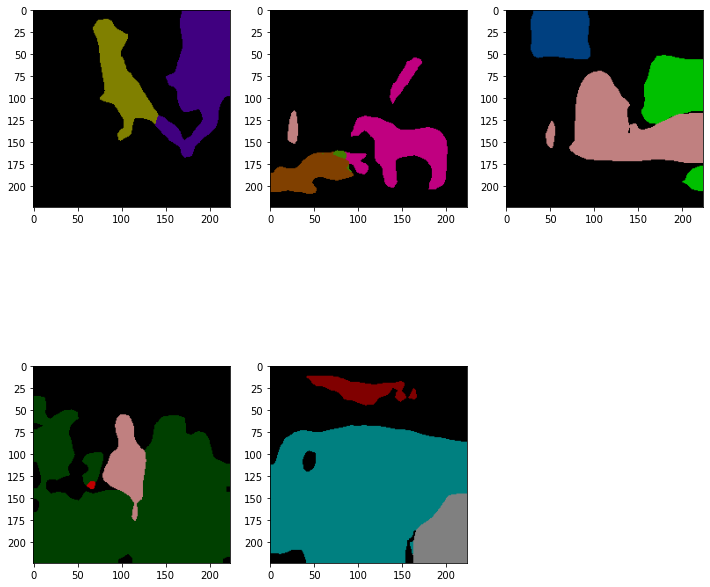

In [14]:
# Use the helper function to generate the segmentation maps
colored_image1 = segmentation_map_key(output_max_1)
colored_image2 = segmentation_map_key(output_max_2)
colored_image3 = segmentation_map_key(output_max_3)
colored_image4 = segmentation_map_key(output_max_4)
colored_image5 = segmentation_map_key(output_max_5)

# Show the five output images
output_images = plt.figure(figsize=(12, 12))

output_images.add_subplot(2, 3, 1)
plt.imshow(colored_image1)

output_images.add_subplot(2, 3, 2)
plt.imshow(colored_image2)

output_images.add_subplot(2, 3, 3)
plt.imshow(colored_image3)

output_images.add_subplot(2, 3, 4)
plt.imshow(colored_image4)

output_images.add_subplot(2, 3, 5)
plt.imshow(colored_image5)

plt.show()